### Credits : https://github.com/lukysummer/Movie-Review-Sentiment-Analysis-LSTM-Pytorch/blob/master/sentiment_analysis_LSTM.py

### Dataset from https://ai.stanford.edu/~amaas/data/sentiment/

In [1]:
# loading basic libraries
import numpy as np
import pandas as pd
from wordcloud import WordCloud
from string import punctuation
import torch
import nltk
import matplotlib.pyplot as plt
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to /home/u33552/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#loading the dataset
review_data = pd.read_excel('movie_data.xlsx')
review_data.replace(pd.np.nan,'',inplace=True,regex=True)
review_data.head()

,review,label
0,it's a lovely movie it deeply reflects the Chi...,1
1,This 1998 film was based on a script by the la...,1
2,If you're going to put on a play within the pr...,1
3,At first sight this movie doesn't look like a ...,1
4,This adaptation of M.R. James's short story 'A...,1


In [3]:
# lets preprocess the data to remove punctuations and special characters. 
# Here wer removed everything that is not a character from a-z both lowercase and uppercase
# here we are also converting all the words to lowercase

review_data['review'] = review_data['review'].str.replace("[^a-zA-Z]"," ").apply(lambda x: str(x).lower())

In [4]:
#loading nltk stopwords for english
from nltk.corpus import stopwords
stopwords_english = stopwords.words('english')

In [5]:
# removing all words stopwords. We will use the nltk library list of stop words

review_data['review'] = review_data['review'].apply(lambda x:' '.join([word for word in str(x).split() if word not in stopwords_english ]))
review_data['review'].head()

0    lovely movie deeply reflects chinese undergrou...
1    film based script late edward wood script feat...
2    going put play within prison walls go top play...
3    first sight movie look like particular great o...
4    adaptation r james short story view hill first...
Name: review, dtype: object

In [6]:
#removing the words with length less than or equal to 2
review_data['review'] = review_data['review'].apply(lambda x:' '.join([word for word in str(x).split() if len(word)>2 ]))


In [7]:
review_data['review'].head()
# data looks good now

0    lovely movie deeply reflects chinese undergrou...
1    film based script late edward wood script feat...
2    going put play within prison walls top playwri...
3    first sight movie look like particular great o...
4    adaptation james short story view hill first s...
Name: review, dtype: object

In [8]:
# lets visualize most common words with wordcloud
# We will do visualization for both negative and positive labels as well as the whole data corpus itself


In [9]:
all_words = ' '.join(review_data['review'].tolist())
negative_words = ' '.join(review_data['review'][review_data['label']==0].tolist())
positive_words = ' '.join(review_data['review'][review_data['label']==1].tolist())

In [10]:
#defining a function that will generate word cloud for us

def generate_wordcloud(text,title):
    wc = WordCloud(width=800, height=400, max_font_size=110)
    wc.generate(text)
    plt.figure(figsize=(10, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()


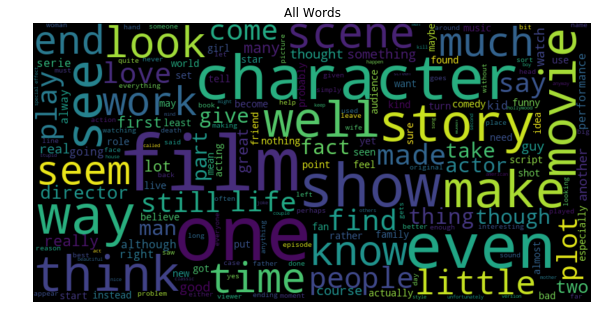

In [11]:
generate_wordcloud(all_words,'All Words')

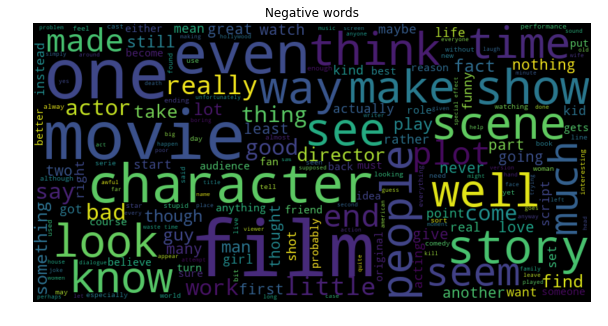

In [12]:
generate_wordcloud(negative_words,'Negative words')

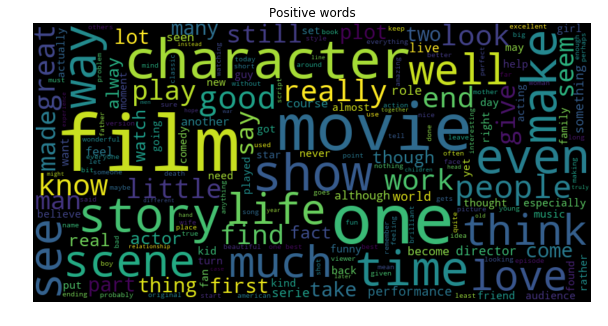

In [13]:
generate_wordcloud(positive_words,'Positive words')

## Create dictionaries and encode reviews

In [14]:
from collections import Counter
word_counts = Counter(all_words.split())
#sorted word list according to descending order. i.e biggest on at first position and so on
word_list = sorted(word_counts, key = word_counts.get, reverse = True)
# creating two dictionaries to map. word to index and map index to word.
# example 1--> movie-->1 --> word to index
# example 2--> movie --> index to word
word_to_index = {word:idx+1 for idx,word in enumerate(word_list)}
index_to_word = {idx+1:word for idx,word in enumerate(word_list)}

In [15]:
#encoding reviews
encoded_reviews = [[word_to_index[word] for word in review.split()] for review in review_data['review']]

## Encode label

In [16]:
encoded_labels = review_data['label']

In [17]:
# len of reviews should be equal to length of labels
assert len(encoded_reviews)==len(encoded_labels),"Number of of encoded reviews and encoded labels should be same"

### Removing empty reviews and labels--> i.e those reviews that had no text.--> they will have empty list in encoded matrix

In [18]:
encoded_labels = [label for idx, label in enumerate(encoded_labels) if len(encoded_reviews[idx])>0]
encoded_reviews =  [review for review in encoded_reviews if len(review)>0]


In [19]:
# len of reviews should be equal to length of labels
assert len(encoded_reviews)==len(encoded_labels),"Number of of encoded reviews and encoded labels should be same"

### Making all reviews of same length i.e padding

In [47]:
#printing top 20 max length
len_max = ([len(x) for x in encoded_reviews])
print(sorted(list(len_max),reverse=True)[:20])

[1390, 1132, 1127, 1080, 920, 905, 889, 870, 802, 789, 787, 772, 727, 701, 690, 684, 673, 669, 629, 625]


In [48]:
# lets see how many reviews have text more than 500
len([review for review in len_max if review>499])

233

In [49]:
# lets see how many reviews have text more than 250
len([review for review in len_max if review>249])

4139

In [55]:
# lets see how many reviews have text more than 150
len([review for review in len_max if review>149])

11458

In [56]:
# lets see how many reviews have text more than 100
len([review for review in len_max if review>99])

20754

In [57]:
# lets see how many reviews have text less than 100
len([review for review in len_max if review<100])

29243

looks like majority of reviews have length less than 100. 

so a standard size of 250 should be enough to get all the features of a review.

also probably people will have expressed how they feel in their first 250 words.

so lets fix a standard review size of 250. in case if reviews are short. we will pad zeros. 

and in case reviews are long we will truncate them

In [ ]:
# function to pad our encoded reviews/feature
def pad_features(reviews,max_length):
    """
    Return features of reviews where each review is padded with 0's or truncted to the max_length
    """
    
    features = np.zeros((len(reviews),max_length),dtype=int) # 2D array of shape len(reviews) * max_length
    
    #pad or truncate each review
    for idx,row in enumerate(reviews):
        features[i,-len(row):]  = np.array(row)[:max_length]
        
    return features

In [ ]:
np